# Assignment 4
Training a simple neural net for relation classification.

In [1]:
!pip install transformers
!pip install torchinfo
!pip install torch-info
!pip install torchsummary


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 38.6 MB/s 
     |████████████████████████████████| 6.6 MB 41.6 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch-info (from versions: none)
ERROR: No matching distribution found for torch-info
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install turchsummary
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement turchsummary (from versions: none)
ERROR: No matching distribution found for turchsummary
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn as nn
from google.colab import drive
import torch
import torch.nn as nn
import tensorflow as tf
import os


import numpy as np
import math
from tabulate import tabulate

from sklearn.metrics import classification_report
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AutoConfig, AutoModel
from torchsummary import summary
from numpy.random import default_rng
import gc
import pandas as pd 
from tqdm.notebook import tqdm_notebook
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In this assignment you are required :
## to build a full training and testing pipeline for a neural relation classification (RC), using BERT.

1. The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf). 
2. The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.
3. The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)
4. In this work we will use the hugingface framework for transformers training and inference.
5. We recomand reading the d4.ocumentation in https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification *before* you start coding. 


**Task 1:** 
## Write a funtion *read_data* for reading the data from a single file (either train or test). 
1. This function recieves a filepath and returns a list of sentence.
2. Every sentence is encoded as a touple
    * first element is the sentence string
    * second the label (also represented as a sting). 

In [4]:
!git clone https://github.com/kfirbar/nlp-course

Cloning into 'nlp-course'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 71 (delta 29), reused 40 (delta 11), pack-reused 0
Unpacking objects: 100% (71/71), done.


In [5]:
# general folder path
drive_path = '/content/gdrive'
drive_saving_path = '/content/gdrive/My Drive'
drive.mount(drive_path)

Mounted at /content/gdrive


In [6]:
User = 'Drive'

if User == 'Or':
    train_path = r'C:\MSC\NLP2\HW4\TRAIN_FILE.TXT'
    test_path = r'C:\MSC\NLP2\HW4\TEST_FILE_FULL.txt'
else:
    main_folder = os.path.join(drive_saving_path, 'NLP4')
    train_path = os.path.join(main_folder, 'TRAIN_FILE.TXT')
    test_path = os.path.join(main_folder, 'TEST_FILE_FULL.TXT')

   


In [7]:

def read_data(filepath):
    """
    Parameters
    ----------
    filepath : string
    DESCRIPTION:
        1. for given path we read the txt file into list 
        2. for each sentence is shift of 4 index 0,4,8,....,4n, the label
           is the same only from the index 1,5,9,...4n+1
        3. first we will slice the sentences, and labels 
        4. for each setnence we will remodve the TAB & "\n" 
            ([1:-1] to remove the double quating ) 
        
          for each labels needed to remove  space and "\n"
        5. finnaly we need to concat setence to label to list of tupples 
    Returns
    -------
    data : list 
        list of tupples [ (sentence, label), (), ....].
    """
    # 1
    with open(filepath) as file:
        output = file.readlines()
    
    # 2
    STEP = 4
    
    # 3
    labels  = output[1::STEP]
    sentences  = output[0::STEP]

    #4 
    # sentence splited
    sentences = list(map(lambda x: x.split('\t')[1].replace('\n', '').replace('</e2>', '').replace('</e1>', '').replace('<e1>', '').replace('<e2>', '')[1:-1], sentences))
    labels = list(map(lambda x: x.replace('\n', '').replace('(e2,e1)', '').replace('(e1,e2)', ''), labels))

    # 5
    data = list(zip(sentences, labels))
    
    return data

train = read_data(train_path)
test = read_data(test_path)

Pytorch require the labels to be integers. Create a mapper (dictionary) from the string labels to integers (starting zero). 

In [8]:
def from_list_of_list_2_single_list(list_of_list):
    # convertign list of list to single list with all ellements
    flat_list = [item for sublist in list_of_list for item in sublist]
    return flat_list

def get_unique_tokens_and_token_indexs(data, is_sentence = True):
    """
    Parameters
    ----------
    data : list of tuples 
        contain list of tuples (sentences, labels)
    is_sentence : Bollan
        indicate whether to get setnece or label
    
    
    1. get desire list sentences\labels 
    2. split into tokens
    3. convert to single list with all ellements
    4. doing unique the list to get unique value and index 
    5. generate dict\mapper from token 2 index
    
    Returns
    -------
    mapper_dict : dict
        map from unique token to unique index

    """
    #1
    if is_sentence:
        list_of_list = list(map(lambda x: x[0], data))

    # label
    else: 
        list_of_list = list(map(lambda x: x[1], data))
    
    #2
    list_of_list_tokens = list(map(lambda x: x.split(' '), list_of_list))
    #3
    all_tokens = from_list_of_list_2_single_list(list_of_list_tokens)
    #4
    unique_tokens =list(set(all_tokens))
    #5
    mapper_dict = dict(zip(unique_tokens,np.arange(0, unique_tokens.__len__())))
    return mapper_dict

def create_label_mapper(data):
    """
    Parameters
    ----------
    data : list of tuples 
        contain list of tuples (sentences, labels)
    Returns
    -------
    sentences_mapper : dict
        map from unique token to unique index
    labels_mapper : dict
        map from unique token to unique index
    """ 
    #sentences_mapper = get_unique_tokens_and_token_indexs(data, is_sentence = True)
    labels_mapper = get_unique_tokens_and_token_indexs(data, is_sentence = False)
    return labels_mapper

In [9]:
label_mapper = create_label_mapper(train)
labels = list(label_mapper.keys())
num_labels = labels.__len__()
label_mapper

{'Cause-Effect': 2,
 'Component-Whole': 4,
 'Content-Container': 1,
 'Entity-Destination': 6,
 'Entity-Origin': 5,
 'Instrument-Agency': 7,
 'Member-Collection': 9,
 'Message-Topic': 8,
 'Other': 3,
 'Product-Producer': 0}

**Task 2:** 
## Write a function *prepare_data* that 
1. takes one of the [train, test] datasets and convert each pair of (words,labels) to a pair of indexes. 
2. The function also aggregate the samples into batches. 
3. BERT Uses pretrained tokanization and embedding. 
4. you can access the tokanization and indexing using the BertTokenizer class.


In [10]:
def get_single_input(i_data, label_tuple_idx, labels_mapper, sentence_tuple_idx, tokenizer, num_labels = 10):
    """
    getting tuple size 3 base data item  (tensor input, mask tensor, label iteger)
    """
    # get setnece and label
    i_sentence = i_data[sentence_tuple_idx]
    i_label = i_data[label_tuple_idx]
    # do tokenization to the setnence
    # i_tensor_input = tokenizer(i_sentence, return_tensors="pt")
    i_tensor_input = tokenizer(i_sentence,  truncation=True, padding='max_length',return_tensors="pt")

    i_tensor_input = list(i_tensor_input.values())
    # get label
    i_label = labels_mapper[i_label]
    # print(i_label)
    label_array = np.zeros((1,num_labels))
    label_array[0,int(i_label)] = 1 
    i_label = torch.tensor(label_array)
    # insert all to tupple
    # single_input = (input_ids, attn_mask, i_label)
    # single_input = (i_tensor_input, i_label)

    return i_tensor_input, i_label

def prepare_data(data, tokenizer, batch_size=8, num_labels = 10):
    """
    Parameters
    ----------
    data : list of tuples 
        contain list of tuples (sentences, labels)
    tokenizer : generator of transformers pakage
        for given sentence return dict of:
            1. input idx - tensor
            2. mask  - tensor 
            3. attention_mask - tensor
            
    batch_size : int, optional
        DESCRIPTION. The default is 8, the size of batch, after 8 input model will do backprop'.

    Returns
    -------
    data_sequences : list of tuples 
        the input to our model

    """
    data_sequences = []
    sentence_tuple_idx = 0
    label_tuple_idx = 1

    labels_mapper = create_label_mapper(data)
    for sentence_idx, i_data in enumerate(data):
      
            
        # 
        i_tensor_input, i_label = get_single_input(i_data, label_tuple_idx, labels_mapper, sentence_tuple_idx, tokenizer, num_labels)


        # initiate batch input list
        if sentence_idx ==0 or ids_tensor.shape[0]%batch_size == 0 :
            # print(sentence_idx)
            # print(batch_size)

            ids_tensor = i_tensor_input[0]
            idx_tensor = i_tensor_input[1]
            attention_mask_tensor = i_tensor_input[2]
            label_tensor = i_label
        else:
            # append batch data
            # print(sentence_idx)
            ids_tensor = torch.concat((ids_tensor, i_tensor_input[0]), axis = 0)
            idx_tensor = torch.concat((idx_tensor, i_tensor_input[1]), axis = 0)
            attention_mask_tensor = torch.concat((attention_mask_tensor, i_tensor_input[2]), axis = 0)
            label_tensor = torch.concat((label_tensor, i_label), axis = 0)

        # if batch list is fill append batch data to all data 
        if ids_tensor.shape[0]%(batch_size) == 0:
            batch_data = [[ids_tensor, idx_tensor, attention_mask_tensor], label_tensor]
            data_sequences.append(batch_data)
    
    padd_last_batch_size =  8 - ids_tensor.shape[0] 
    if padd_last_batch_size>0:
        rng = default_rng()
        choosen_idx = \
            rng.choice(range(0, data.__len__()-padd_last_batch_size), size=padd_last_batch_size, replace=False)
        for i_idx in choosen_idx:
            
            i_data = data[i_idx]
            
            # get single input
            i_tensor_input, i_label = get_single_input(i_data, label_tuple_idx, labels_mapper, sentence_tuple_idx, tokenizer)
            
            # append batch data
            ids_tensor = torch.concat((ids_tensor, i_tensor_input[0]), axis = 0)
            idx_tensor = torch.concat((idx_tensor, i_tensor_input[1]), axis = 0)
            attention_mask_tensor = torch.concat((attention_mask_tensor, i_tensor_input[2]), axis = 0)
            label_tensor = torch.concat((label_tensor, i_label), axis = 0)


        # append batch data
        batch_data = [[ids_tensor, idx_tensor, attention_mask_tensor], label_tensor]
        data_sequences.append(batch_data)       

    return data_sequences

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_sequences = prepare_data(train, tokenizer)
test_sequences = prepare_data(test, tokenizer)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Task 3:** 
## In this part we classify the sentences using the BertForSequenceClassification model.
1. To save resources, we initialize the optimizer with the final layer of the model. 
2. You are also allowed to change the learning rate.

In [11]:
def get_parameters(params):
    """
    Parameters
    ----------
    params : pythorch model.named_parameters()

    Returns
    -------
    layers : TYPE
        DESCRIPTION.
    """
    # initiate layers 
    layers = []
    # run on all model layers 
    for name, param in params:
        # set when on which layer needed to do backprop'
        param.requires_grad = 'classifier' in name
        # append layer
        layers.append(param)
        # print(name)

    return layers




## laod  model and print his summary

In [71]:
# constants
batch_size = 8
epochs = 80
lr = 1e-2

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
# i_tensor_input = tokenizer('i love shira and my self and my mine to ', padding='max_length', truncation=True, return_tensors="pt")
# i_tensor_input2 = tokenizer('i pick my self', padding='max_length', truncation=True, return_tensors="pt")

# i_tensor_input = list(i_tensor_input.values())
# i_tensor_input2 = list(i_tensor_input2.values())


In [14]:
#  i_tensor_input11 = torch.concat((i_tensor_input[0], i_tensor_input2[0]), axis = 0)
#  i_tensor_input22 = torch.concat((i_tensor_input[1], i_tensor_input2[1]), axis = 0)
#  i_tensor_input33 = torch.concat((i_tensor_input[2], i_tensor_input2[2]), axis = 0)
# label_tensor = torch.empty(2,num_labels)

# logits = model(i_tensor_input11.to(device), i_tensor_input22.to(device), i_tensor_input33.to(device), return_dict=False)
# logits
# criterion = nn.CrossEntropyLoss()
# criterion(logits[0], label_tensor.to(device)).backward()

# # inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# # inputs
# # labels = torch.tensor(1)
# # labels
# # model(**inputs)

In [15]:
# logits[0].shape

In [16]:
# train_sequences[0]

## set optimizer

In [17]:
# Optimizer (ADAM is a fancy version of SGD)
optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=lr)

**Task 4:** 
## Write a training loop
1. takes a BertForSequenceClassification model 
2. train for number of epochs to train on.
3. The loss is always CrossEntropyLoss 
4. optimizer is always Adam. 
5. You are allowed to split the train to train and dev sets.

In [114]:
def predict_batch_results(train_data):
  prediction_res = []
  for i_input in train_data:
    # get inputs
    i_input_ids = i_input['input_ids']
    i_attn_mask = i_input['attention_mask']
    i_token_type_ids = i_input['token_type_ids']

    # predict results
    logits = model(i_input_ids.to(device), i_attn_mask.to(device), i_token_type_ids.to(device))
    i_logits = logits['logits']

    # append results
    prediction_res.append(i_logits)
  return prediction_res



def get_model_results(model, test_sequences):
    """
    Parameters
    ----------
    model : Torch model  - 
        DESCRIPTION: LSTM model.
    test_sequences : list
        DESCRIPTION: input list of coupels [[word_tensor, lebel_tensor] , ...]
    
    the function get model results
    
    Returns
    -------
    all_test_words_pred : list
    all_test_words_true : list
    """
    # generate test tokens prediction
    all_test_words_pred = []
    all_test_words_true = []


    # ids_tensor = list(map(lambda x: x[0][0], test_sequences))
    # idx_tensor = list(map(lambda x: x[0][1], test_sequences))
    # attention_mask_tensor = list(map(lambda x: x[0][2], test_sequences))
    # labels = list(map(lambda x: x[1], test_sequences))

    # ids_tensor = torch.concat((ids_tensor), axis = 0)
    # idx_tensor = torch.concat((idx_tensor), axis = 0)
    # attention_mask_tensor = torch.concat((attention_mask_tensor), axis = 0)
    # labels = torch.concat((labels), axis = 0)
    for sentence, labels in test_sequences:
        ids_tensor = sentence[0]
        idx_tensor = sentence[1]
        attention_mask_tensor = sentence[2]

        labels_tensor = labels.to(device)
        logits = model(ids_tensor.to(device), idx_tensor.to(device), attention_mask_tensor.to(device))
        logits = logits.logits
        
        _, pred_labels =logits.T.max(0)
        _, labels =labels.T.max(0)

        all_test_words_pred += pred_labels.tolist()
        all_test_words_true += labels.tolist()

    return all_test_words_pred, all_test_words_true

def train_loop(model, n_epochs, train_data, label_mapper, dev_data = None, alpha_zero = 1e-3 ):

  update_lr_after_n_aphoc = 1  
  # alpha_zero = 1e-2
  # Loss function
  criterion = nn.CrossEntropyLoss()
  all_target_names = list(label_mapper.keys())

  optimizer = torch.optim.Adam(model.parameters(), lr=alpha_zero)

  
  curr_f1_accuracy_result = 0
  best_f1_accuracy_result = 0
  best_df = pd.DataFrame()
  old_lr  = alpha_zero
  for ephoc_index in range(1, n_epochs + 1):

    desc = ('Ephoc #' + str(ephoc_index))
    for sequence_idx in tqdm_notebook(range(train_data.__len__()), desc = desc):
        
        
        # get sentence tokens, and labels 
        batch_data =  train_sequences[sequence_idx]

        train_data = batch_data[0]
        train_labels = batch_data[1]

        # input_ids_train ,train_attention_mask, train_labels = train_sequences[sequence_idx]
        if not dev_data is None:
            dev_sentence ,dev_mask, dev_labels = train_sequences[sequence_idx]

        # check if there is empty sentence
        if train_labels.shape[0] == 0:
            continue
    
        
        # Sets the gradients of all optimized to zero.
        model.zero_grad()
        
        # foward sentence to model
        ids_tensor = train_data[0]
        idx_tensor = train_data[1]
        attention_mask_tensor = train_data[2]
        logits = model(ids_tensor.to(device), idx_tensor.to(device), attention_mask_tensor.to(device))
        logits = logits.logits

        # Computes the gradient of current tensor
        criterion(logits, train_labels.to(device)).backward()
        
        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # once the gradients are computed use them to optimize model
        optimizer.step()
    
    
    cos_inner = np.pi * (ephoc_index % (n_epochs // update_lr_after_n_aphoc))  
    cos_inner /= n_epochs // update_lr_after_n_aphoc
    cos_out = np.cos(cos_inner) + 1
    new_lr = float(alpha_zero / 2 * cos_out) # needed to be seen
    lr_string = '\nlearning rate we decay from value = ' + str(new_lr) + ' to the value = '+ str(old_lr)
    old_lr  = new_lr

    optimizer = torch.optim.Adam(model.parameters(), lr=new_lr)

    # torch.cuda.empty_cache()
    # gc.collect()
    print('finshed ephoc #' + str(ephoc_index) + ', ephoch results:' , flush = True)
    all_train_words_pred, all_train_words_true = get_model_results(model, train_sequences)
    curr_f1_accuracy_result = f1_score(all_train_words_true, all_train_words_pred,  average='macro')

    # train_Results_df = pd.DataFrame(classification_report(all_train_words_true, all_train_words_pred, target_names = all_target_names, output_dict = True))
    # curr_f1_accuracy_result = train_Results_df.iloc[2]['accuracy']

    if curr_f1_accuracy_result > best_f1_accuracy_result:
      improve_string = 'f1-accuracy-score improve from ' + str(best_f1_accuracy_result) + ' to ' + str(curr_f1_accuracy_result) 
      best_f1_accuracy_result = curr_f1_accuracy_result
      # best_df = train_Results_df
    else:
      improve_string = 'f1-accuracy-score did not improve from ' + str(best_f1_accuracy_result)  
    improve_string += lr_string
    print(improve_string, flush = True)
    torch.cuda.empty_cache()
    gc.collect()
  return model 
    





In [ ]:
  # train_fn, val_fn = train_test_split(train_fn, stratify=train_df.my_labels,test_size=0.1,random_state=10)


In [27]:
# # get sentence tokens, and labels 
# batch_data =  train_sequences[0]

# criterion = nn.CrossEntropyLoss()

# train_data = batch_data[0]
# train_labels = batch_data[1]

# # Sets the gradients of all optimized to zero.
# model.zero_grad()

# # foward sentence to model
# ids_tensor = train_data[0]
# idx_tensor = train_data[1]
# attention_mask_tensor = train_data[2]
# logits = model(ids_tensor.to(device), idx_tensor.to(device), attention_mask_tensor.to(device))
# logits = logits.logits
# logits



# # Computes the gradient of current tensor
# criterion(logits, train_labels.to(device)).backward()

# # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
# torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

# # once the gradients are computed use them to optimize model
# optimizer.step()

In [46]:
# all_target_names = list(label_mapper.keys())
# all_target_names.__len__()
# all_target_names

['Product-Producer',
 'Content-Container',
 'Cause-Effect',
 'Other',
 'Component-Whole',
 'Entity-Origin',
 'Entity-Destination',
 'Instrument-Agency',
 'Message-Topic',
 'Member-Collection']

In [111]:
from sklearn.metrics import f1_score
torch.cuda.empty_cache()
gc.collect()
all_train_words_pred, all_train_words_true = get_model_results(model, train_sequences[0:100])
all_train_words_pred
all_train_words_true
all_target_names = list(label_mapper.keys())
f1_score(all_train_words_true, all_train_words_pred,  average='macro')
# train_Results_df = pd.DataFrame(classification_report(all_train_words_true, all_train_words_pred, target_names = all_target_names, output_dict = True))


0.026652221018418198

In [100]:
all_train_words_pred.__len__()

80

In [55]:
# all_train_words_true
# # all_train_words_pred
# # all_target_names

['Product-Producer',
 'Content-Container',
 'Cause-Effect',
 'Other',
 'Component-Whole',
 'Entity-Origin',
 'Entity-Destination',
 'Instrument-Agency',
 'Message-Topic',
 'Member-Collection']

In [76]:
tt = train_sequences[0:20]

In [88]:

# ids_tensor = list(map(lambda x: x[0][0], tt))
# idx_tensor = list(map(lambda x: x[0][1], tt))
# attention_mask_tensor = list(map(lambda x: x[0][2], tt))
# labels = list(map(lambda x: x[1], tt))

# ids_tensor = torch.concat((ids_tensor), axis = 0)
# idx_tensor = torch.concat((idx_tensor), axis = 0)
# attention_mask_tensor = torch.concat((attention_mask_tensor), axis = 0)
# labels = torch.concat((labels), axis = 0)

# logits = model(ids_tensor.to(device), idx_tensor.to(device), attention_mask_tensor.to(device))
# logits = logits.logits
# logits


# for sentence, labels in test_sequences:
#     ids_tensor = sentence[0]
#     idx_tensor = sentence[1]
#     attention_mask_tensor = sentence[2]

#     labels_tensor = labels.to(device)
#     logits = model(ids_tensor.to(device), idx_tensor.to(device), attention_mask_tensor.to(device))
#     logits = logits.logits
    
#     _, pred_labels =logits.T.max(0)
#     _, labels =labels.T.max(0)

#     all_test_words_pred += pred_labels.tolist()
#     all_test_words_true += labels.tolist()

RuntimeError: ignored

In [93]:
torch.cuda.empty_cache()
import gc
gc.collect()

5494

In [113]:
# train_Results_df = pd.DataFrame(classification_report(all_train_words_true, all_train_words_true, target_names = all_target_names, output_dict = True, zero_division = 0))
# train_Results_df
train_sequences.__len__()

1000

In [ ]:
model = train_loop(model, n_epochs=10, train_data=train_sequences, label_mapper = label_mapper, dev_data=None)


Ephoc #1:   0%|          | 0/1000 [00:00<?, ?it/s]

**Task 5:** write an evaluation loop on a trained model, using the dev and test datasets. This function print the true positive rate (TPR), also known as Recall and the opposite to false positive rate (FPR), also known as precision, of each label seperately (10 labels in total), and for all labels together. The caption argument for the function should be served for printing, so that when you print include it as a prefix.

In [ ]:
def evaluate(model, test_data):
  # TODO - your code goes here
  print(...)

**Task 6:** In this part we'll improve the model accuracy by using a method called "entity markers - Entity start". The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. instead of using the CLS toekn for clasification, we will use the concatination of the embedding of [e1] and [e2] as shown in the image below. The complete method is described in details in the following paper - https://arxiv.org/pdf/1906.03158.pdf (specifically in Section 3.2). To use this method we'll need to create a new data load and a new model.

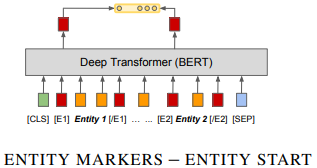

The new methods require the usage of special tokens. The following code will add the required tokens.

In [ ]:
tokenizer.add_tokens(['[E1]', '[/E1]', '[E2]', '[/E2]')

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

In [ ]:
def prepare_data_MTB(data, tokenizer, batch_size=8):
    data_sequences = []
    # TODO - your code...

    return data_sequences

train_sequences = prepare_data_MTB(train, tokenizer)
test_sequences = prepare_data_MTB(test, tokenizer)

Create a new model that uses the "entity markers - Entity start" method.

In [ ]:
class MTB(nn.Module):
    def __init__(self, base_model_name):
      config = AutoConfig.from_pretrained(name)
      self.model = AutoModel.from_config(config)
      # TODO - your code...
    def forward(self, input, index):
      # TODO - your code...
model = MTB('bert-base-uncased')

Use the new dataloader and model to train and evaluate the new model as in task 4 and 5

In [ ]:
train_loop(model, n_epochs, train_data, dev_data)
evaluate(model, test_data)


**Good luck!**